In [2]:
from backtesting import Backtest
from TradingFunctions import SuperStategy,getDataset

import numpy as np
import matplotlib.pyplot as plt

from mealpy import FloatVar
from mealpy.utils.problem import Problem
from mealpy.physics_based.ASO import OriginalASO
from mealpy.physics_based.SA import GaussianSA
from mealpy.evolutionary_based.GA import BaseGA
import warnings


In [3]:
# ================
#   LOAD DATASET
# ================
dataset_train,dataset_test = getDataset('dataset.csv')


/home/andrew/Documentos/smarttrade/smarttrade-optimizacion/TradingFunctions.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dataset_train = [g for n, g in dataset_train.groupby(pd.Grouper(freq='M'))][1:-1]           # ME en LOCAL, M en colab


In [4]:
# ================
#   SIMPLE TEST
# ================

scores = []
for periodo in dataset_train:
    bt = Backtest(periodo, SuperStategy,cash=1e6, commission=.0005,exclusive_orders=True)
    output = bt.run(x = [14.196, 19.427, 14.472, 31.150, 3.010, 3.279, 3.493, 3.382])
    scores.append( 1+output['Return [%]']/100 )

print(np.mean(scores),np.std(scores))

1.0744614732807358 0.08046015427851999


In [ ]:
warnings.filterwarnings("ignore")

# ==========================================
# ============ OPTIMIZACION ================
# ==========================================

class TradingProblem(Problem):
    def __init__(self, bounds, trading_strategy, dataset, minmax='max', **kwargs):

        self.trading_strategy = trading_strategy
        self.dataset = dataset
        super().__init__(bounds, minmax, **kwargs)

    def obj_func(self,solution):
        
        scores = []
        for periodo in self.dataset:
            bt = Backtest(periodo, self.trading_strategy,cash=1e6, commission=.0005,exclusive_orders=True)
            output = bt.run(x = solution)
            scores.append( output['Return [%]'] )
        
        return np.mean(scores) 
        

bounds = FloatVar(lb=[5,  5,  5,  0.7,0.7,0.7,0.7,0.7], 
                  ub=[288,288,288,2.0,3.0,3.0,3.0,3.0])

trading_problem = TradingProblem(bounds,SuperStategy,dataset_train)
model = BaseGA(30,20)
# # model = GaussianSA(40,2)
solution = model.solve(trading_problem)

In [6]:
# ==========================================
# ============= VALIDATION =================
# ==========================================
x = np.array([14.196843590886687, 19.427075906537134, 14.472545933461255, 31.150586131521226, 3.01065551126368, 3.2799685430480334, 3.493723878682184, 3.3829061923576824])

bt = Backtest(data, SuperStategy, cash=1e6, commission=.0005,exclusive_orders=True)
output = bt.run(x=x)
output

Start                     2019-12-31 21:00:00
End                       2024-02-29 20:55:00
Duration                   1520 days 23:55:00
Exposure Time [%]                   14.997443
Equity Final [$]               5438780.414489
Equity Peak [$]                6806038.752268
Return [%]                         443.878041
Buy & Hold Return [%]              753.257178
Return (Ann.) [%]                   50.101509
Volatility (Ann.) [%]               36.547882
Sharpe Ratio                         1.370846
Sortino Ratio                        3.643615
Calmar Ratio                         1.743999
Max. Drawdown [%]                  -28.727952
Avg. Drawdown [%]                   -1.129378
Max. Drawdown Duration      411 days 15:10:00
Avg. Drawdown Duration        3 days 13:57:00
# Trades                                 1364
Win Rate [%]                         56.01173
Best Trade [%]                      13.696427
Worst Trade [%]                    -16.618985
Avg. Trade [%]                    

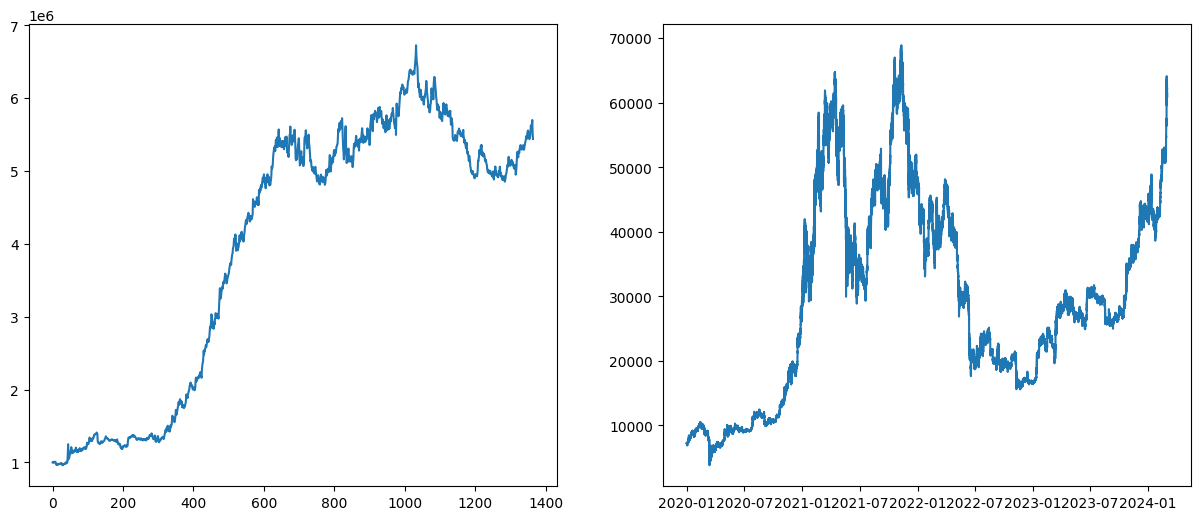

In [7]:
# ==========================================
# ================= TRADES =================
# ==========================================

money = [1e6]
for pnl in output['_trades']['PnL']:
    money.append(money[-1]+pnl)

fig,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].plot(money)
ax[1].plot(data['Close'])
plt.show()